In [1]:
from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import init_hnet
from gsnn.models import GSNN

import networkx as nx
from matplotlib import pyplot as plt
import torch
import numpy as np 

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

%load_ext autoreload
%autoreload 2


/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Uncertainty quantification with hypernetworks

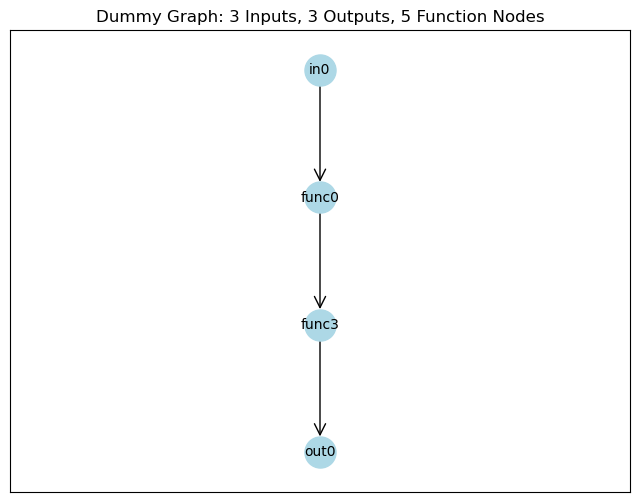

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0',]
function_nodes = ['func0', 'func3', ]
output_nodes = ['out0']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2),
    'func0': (-2, 1), 
    'func3': (-2, 0), 'func4': (1, 0),
    'out0': (-2, -1),
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
special_functions = {'func0': lambda x: np.sin(2*np.mean(([(xx) for xx in x]))), 'func3': lambda x: 5*np.sum(x)}

x_train, x_test, y_train, y_test = simulate(G, n_train=500, n_test=0, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.25)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)
y_train = (y_train - y_mu)/(y_std + 1e-8)

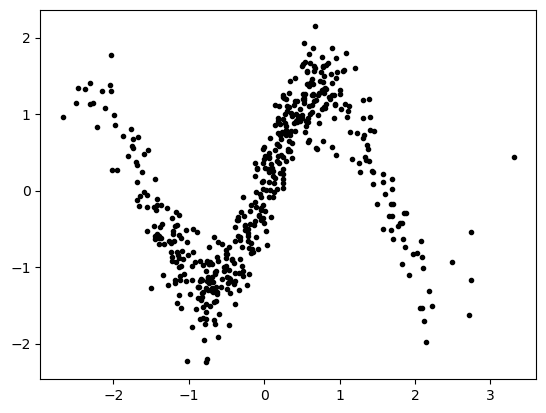

In [4]:
plt.figure()
plt.plot(x_train.detach().cpu().numpy().ravel(), y_train.detach().cpu().numpy().ravel(), 'k.')
plt.show()

In [5]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

gsnn = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=30, 
             layers=2,
             share_layers=False, 
             bias=True,
             add_function_self_edges=True,
             norm='layer', 
             dropout=0,
             dropout_type='channel')

model = HyperNet(gsnn, stochastic_channels=10, width=20).to(device)

print('n params (gsnn)', sum([p.numel() for p in gsnn.parameters()]))
print('n params (hypernet)', sum([p.numel() for p in model.parameters()]))

n params (gsnn) 618
n params (hypernet) 13202


## Hypernetwork initialization 

Hypernets are neural networks that predict the parameters of another network. Due to this, the hypernetwork samples will be roughly normally distributed. To adapt this to a specific neural network architecture we specify the desired mean and variances of the variance parameters and train the hypernetwork using moment-matching. 

Note that this isn't an essential step, particularly if you are using Adaptive optimizers (like Adam). Considering the simplicity of our network, initialization parameters won't have a significant effect. 

In [6]:
init_ = True
eps = 1e-1

if init_ : 
    init_dict = {}
    for i,blk in enumerate(model.model.ResBlocks): 
        init_dict[f'ResBlocks.{i}.lin1.values'] = (torch.zeros_like(blk.lin1.init_var.cpu()), blk.lin1.init_var.cpu())
        init_dict[f'ResBlocks.{i}.lin3.values'] = (torch.zeros_like(blk.lin3.init_var.cpu()), blk.lin3.init_var.cpu())
        if hasattr(blk.lin1, 'bias'): 
            init_dict[f'ResBlocks.{i}.lin1.bias'] = (eps*torch.ones_like(blk.lin1.bias.cpu()), eps*torch.ones_like(blk.lin1.bias.cpu()))
            init_dict[f'ResBlocks.{i}.lin3.bias'] = (eps*torch.ones_like(blk.lin3.bias.cpu()), eps*torch.ones_like(blk.lin3.bias.cpu()))
        if blk.norm == 'layer':
            gamma = blk.norm1.gamma.cpu()
            init_dict[f'ResBlocks.{i}.norm1.gamma'] = (torch.ones_like(gamma), eps*torch.ones_like(gamma))
            beta  = blk.norm1.beta.cpu()
            init_dict[f'ResBlocks.{i}.norm1.beta'] = (eps*torch.ones_like(beta), eps*torch.ones_like(beta))
            
    T = init_hnet(model.cpu(), init_dict, samples=100, iters=250, lr=1e-2)
    T = T.to(device)

In [7]:
samples = 100

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train, samples=samples)   # shape: (samples, batch, features)
                                             # y shape (batch, features)
    loss = crit(yhat, y_train.unsqueeze(0).expand(samples, -1, -1))
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/torch_geometric/utils/_scatter.py:75: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return src.new_zeros(size).scatter_add_(dim, index, src)
/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/torch_geometric/utils/_scatter.py:79: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  count.scatter_add_(0, index, src.new_ones(src.size(dim)))
/home/teddy/miniconda3/envs/gsnn/lib/py

In [8]:
xx = torch.linspace(-5,5,1000, device=device).unsqueeze(-1)
yhat = model(xx, samples=500)

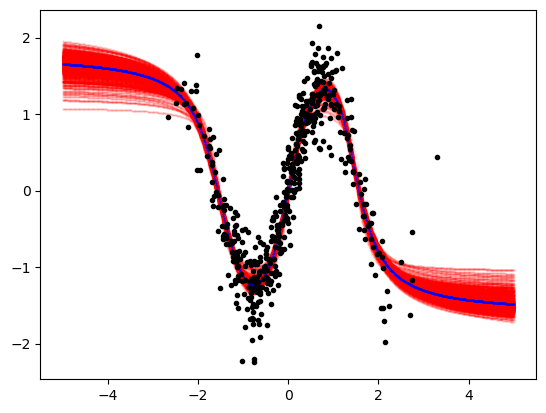

In [9]:
plt.figure()
plt.plot(x_train.detach().cpu().numpy().ravel(), y_train.detach().cpu().numpy().ravel(), 'k.')
for yyhat in yhat.detach().cpu().numpy(): 
    plt.scatter(xx.detach().cpu().numpy(), yyhat, c='r', marker='.', s=1, alpha=0.1)
plt.scatter(xx.detach().cpu().numpy(), yhat.mean(0).detach().cpu().numpy(), c='b', marker='.', s=1, alpha=1)
plt.show()

# Training with Negative Log-liklihood 

In [10]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

gsnn = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=30, 
             layers=2,
             share_layers=False, 
             bias=True,
             add_function_self_edges=True,
             norm='layer', 
             dropout=0,
             dropout_type='channel')

model = HyperNet(gsnn, stochastic_channels=10, width=20).to(device)

print('n params (gsnn)', sum([p.numel() for p in gsnn.parameters()]))
print('n params (hypernet)', sum([p.numel() for p in model.parameters()]))

n params (gsnn) 618
n params (hypernet) 13202


In [11]:
init_ = True
eps = 1e-4

if init_ : 
    init_dict = {}
    for i,blk in enumerate(model.model.ResBlocks): 
        init_dict[f'ResBlocks.{i}.lin1.values'] = (torch.zeros_like(blk.lin1.init_var.cpu()), blk.lin1.init_var.cpu())
        init_dict[f'ResBlocks.{i}.lin3.values'] = (torch.zeros_like(blk.lin3.init_var.cpu()), blk.lin3.init_var.cpu())
        if hasattr(blk.lin1, 'bias'): 
            init_dict[f'ResBlocks.{i}.lin1.bias'] = (eps*torch.ones_like(blk.lin1.bias.cpu()), eps*torch.ones_like(blk.lin1.bias.cpu()))
            init_dict[f'ResBlocks.{i}.lin3.bias'] = (eps*torch.ones_like(blk.lin3.bias.cpu()), eps*torch.ones_like(blk.lin3.bias.cpu()))
        if blk.norm == 'layer':
            gamma = blk.norm1.gamma.cpu()
            init_dict[f'ResBlocks.{i}.norm1.gamma'] = (torch.ones_like(gamma), eps*torch.ones_like(gamma))
            beta  = blk.norm1.beta.cpu()
            init_dict[f'ResBlocks.{i}.norm1.beta'] = (eps*torch.ones_like(beta), eps*torch.ones_like(beta))
            
    T = init_hnet(model.cpu(), init_dict, samples=100, iters=250, lr=1e-2)
    T = T.to(device)

In [ ]:
samples = 100

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
crit = torch.nn.GaussianNLLLoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train, samples=samples)   # shape: (samples, batch, features)
                                             # y shape (batch, features)
    loss = crit(yhat.mean(0), y_train, yhat.var(0))
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

In [16]:
xx = torch.linspace(-5,5,1000, device=device).unsqueeze(-1)
yhat = model(xx, samples=500)

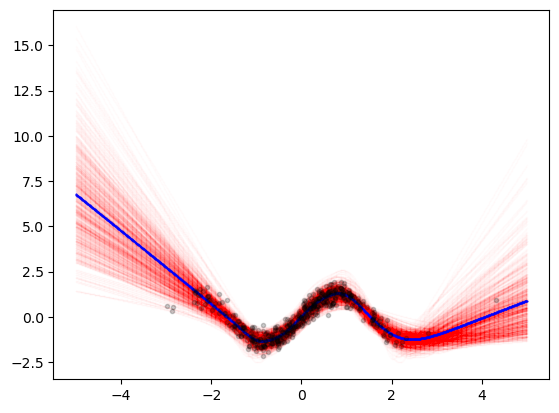

In [19]:
plt.figure()
plt.plot(x_train.detach().cpu().numpy().ravel(), y_train.detach().cpu().numpy().ravel(), 'k.', alpha=0.2)
for yyhat in yhat.detach().cpu().numpy(): 
    plt.scatter(xx.detach().cpu().numpy(), yyhat, c='r', marker='.', s=1, alpha=0.01)
plt.scatter(xx.detach().cpu().numpy(), yhat.mean(0).detach().cpu().numpy(), c='b', marker='.', s=1, alpha=1)
plt.show()

# 